<a href="https://colab.research.google.com/github/MATPETSPACE/algo_trading_strategies/blob/master/Projet_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

PROJET SANS ANALYSE DE SENTIMENTS

In [1]:
#Librairies
import os
import pandas as pd
import tweepy as tw
from pandas_datareader import data
import matplotlib.pyplot as plt
import numpy as np
import datetime
import plotly
from plotly.graph_objs import *

In [2]:
ticker = 'BTC-USD'
start = '2017-10-01'
end = '2021-01-01'
short_lookback_period = 40
long_lookback_period = 100
initial_capital = 10000
nbre_shares = 100

In [3]:
def DataDownloader( ticker, start, end):
    '''
    This function downloads financial data for a given company (ticker), in a daily basis from start to end.
    Inputs: ticker, start, end
    Output: the stock price
    '''
    stock_prices = data.get_data_yahoo( ticker, start, end)
    return stock_prices

In [4]:
def Strategy(short_lookback_period,long_lookback_period): 
    '''
    This function creates the trading strategy.
    Inputs: short_lookback_period in days
            long_lookback_period in days
    Output: 2 dataframes
    '''
    ticker_data = DataDownloader(ticker, start, end)

    # Prepare a signal dataframe with Date same as from ticker data
    signals = pd.DataFrame(index=ticker_data.index)
    signals['signal'] = 0.0

    # Short moving average 
    signals['short_mavg'] = ticker_data['Close'].rolling(window=short_lookback_period, min_periods=1, center=False).mean()

    # Long moving average
    signals['long_mavg'] = ticker_data['Close'].rolling(window=long_lookback_period, min_periods = 1, center=False).mean()

    # Identify cross overs : when short moving avg is greater than long moving average
    signals['signal'][short_lookback_period:] = np.where(signals['short_mavg'][short_lookback_period:] > signals['long_mavg'][short_lookback_period:], 1.0, 0.0) # Value 1 if True, Value 0 if False

    signals['position'] = signals['signal'].diff()

    # Where position is 1
    display(signals[signals.position == 1.0].head())
            
    # Where position is -1
    display(signals[signals.position == -1].head())

In [5]:
Strategy(40,100)

,signal,short_mavg,long_mavg,position
Date,,,,
2017-11-10,1.0,5824.698987,5790.041456,1.0
2018-08-21,1.0,7061.695959,7045.812974,1.0
2019-03-09,1.0,3730.861841,3728.499934,1.0
2020-01-30,1.0,8098.451331,8072.831279,1.0
2020-05-15,1.0,8076.017847,8023.004531,1.0


,signal,short_mavg,long_mavg,position
Date,,,,
2018-02-11,0.0,11713.780542,11846.533413,-1.0
2018-09-04,0.0,6898.901978,6912.999082,-1.0
2019-09-16,0.0,10396.817554,10464.449297,-1.0
2020-03-22,0.0,8196.094128,8242.694751,-1.0
2020-10-13,0.0,10685.782959,10704.738691,-1.0


In [6]:
ticker_data = DataDownloader(ticker, start, end)

In [7]:
def PlotPy(ticker, start, end):
    '''
    This is a function made for plotting purposes.
    Inputs: ticker, start, end
    Output: a plot
    '''
    price = DataDownloader(ticker, start, end)
    close = price['Open']

    fig = plt.figure()

    ax1 = fig.add_subplot(111, ylabel = 'Price')

    # Plot the closing prices
    ticker_data['Close'].plot(ax=ax1, color = 'b', lw=2)

    # Plot the short and long moving average
    signals[['short_mavg','long_mavg']].plot(ax=ax1, lw=2)

    # Plot the buy signal
    ax1.plot(signals.loc[signals.position == 1.0].index, signals.short_mavg[signals.position == 1.0], marker = '^', markersize = 10, color='g', lw=0)

    # Plot the sell signal
    ax1.plot(signals.loc[signals.position == -1.0].index,signals.short_mavg[signals.position == -1.0], marker = 'v', markersize = 10, color='r', lw=0)

    ax1.legend(loc = 2)
    ax1.grid(axis = "both", linestyle = '--')

    plt.show()

NameError: ignored

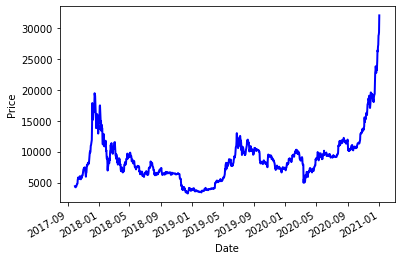

In [8]:
#Example
PlotPy(ticker = 'BTC-USD', start = "2019-10-01", end = "2020-10-01")

In [ ]:
def Backtester(initial_capital, nbre_shares):
    '''
    This is a function made for plotting purposes and results of backest
    Inputs: initial_capital, nbre_shares to buy
    Output: a plot + results of backtest in tab
    '''

    # Positions Dataframe
    positions = pd.DataFrame(index = signals.index)

    # Buy nbre_shares 
    positions['BTC-USD'] = nbre_shares * signals['signal']

    # Initialize the portfolio with values of shares owned
    portfolio = positions.multiply(ticker_data['Close'], axis=0)

    # Stores the difference in shares owned
    pos_diff = positions.diff()

    # Add holdings to portfolio
    portfolio['holdings'] = (positions.multiply(apple_ticker_data['Close'], axis=0)).sum(axis=1)

    # Add cash to portfolio
    portfolio['cash'] = initial_capital - (pos_diff.multiply(apple_ticker_data['Close'], axis=0)).sum(axis=1).cumsum()

    # Total portfolio worth
    portfolio['total'] = portfolio['cash'] + portfolio['holdings']

    # portfolio returns
    portfolio['returns'] = portfolio['total'].pct_change()
    print(portfolio.tail())

    print('-------------------------------------------------------------------------------')

    #Visualization of the performance of the backtested startegy: 
        
    fig = plt.figure()

    ax1 = fig.add_subplot(111, ylabel = "Porfolio value in $")

    portfolio['total'].plot(ax = ax1, color = 'b', lw=2.0)

    # Plot the portfolio on buy signal
    ax1.plot(portfolio.loc[signals.position == 1.0].index,portfolio.total[signals.position == 1.0], marker = '^', markersize = 10, color='g', lw=0)

    # Plot the portfolio on sell signal
    ax1.plot(portfolio.loc[signals.position == -1.0].index,portfolio.total[signals.position == -1.0], marker = 'v', markersize = 10, color='r', lw=0)

In [ ]:
Backtester(10000,100)

KeyError: ignored

In [ ]:
def Eval_perf(returns):
    '''
    This is a function made for evaluation of performance purpose.
    Inputs: retruns : portfolio['returns']
    Output: results of sharpe ratio and CAGR.
    '''

    # annualized sharpe ratio
    sharpe_ratio = np.sqrt(252)*(returns.mean()/returns.std())

    print('The Sharpe Ratio is : ' + str(sharpe_ratio))

    print('-----------------------------------------------------')
    #calculus of CAGR
    days = (ticker_data.index[-1]-ticker_data.index[0]).days
    cagr = ticker_data['Close'][-1] - ticker_data['Close'][1]
    cagr **= (365.0/days)
    cagr -= 1
    print ('The Compound Annualized Growth Rate is : ' + str(cagr))

In [ ]:
Eval_perf(portfolio['returns'])

NameError: ignored

In [ ]:
#MAIN
def Startengine (ticker, start, end, short_lookback_period, long_lookback_period, initial_capital, nbre_shares, returns):
    '''
    This is a function made for starting the trading process.
    Inputs: retruns : ticker, start, end, short_lookback_period, long_lookback_period, initial_capital, nbre_shares, returns
    Output: All our results
    '''

    #Deploiement des fonctions :
    Strategy(short_lookback_period,long_lookback_period)
    print('-------------------------------------------------------------------------------')

    PlotPy(ticker, start, end)
    print('-------------------------------------------------------------------------------')

    Backtester(initial_capital, nbre_shares)
    print('-------------------------------------------------------------------------------')

    Eval_perf(returns)

In [ ]:
#Main function
Startengine('BTC-USD', '2017-10-01', '2021-01-01', 40,100,10000,100,portfolio['returns'])

NameError: ignored